## ДЗ 3. Панков Викентий

./minimap2-2.17_x64-linux/minimap2 -x map-nt -t 8 -a reference.fasta ONT_2D
.fastq.gz > nanopore.sam

./minimap2-2.17_x64-linux/minimap2 -x map-ont -t 8 -a reference.fasta ONT_2
D.fastq.gz > nanopore.sam

** Nanopore: ** 29565 + 0 mapped (92.09% : N/A)  
** PacBio: ** 51199 + 0 mapped (98.31% : N/A)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
  
def plotGenomeCoverage(fileName, avgWindow):
    df = pd.read_csv(fileName, sep="\t", usecols=[1,2], header=None)
    df = df.rename(columns = {1: "genome_position", 2: "depth"})
    df_averaged = df.groupby(np.arange(len(df))//avgWindow).mean()
    df_averaged.plot(x="genome_position", y="depth")
    plt.ylabel("Coverage")
    plt.xlabel("Genome position")
    plt.title("Genome coverage")
    print("Среднее покрытие: ", int(df.depth.mean()))
    print("Доля покрытой области генома: ", df.depth[df.depth>0].count()/len(df)*100, "%")

## Покрытие генома

### Для ридов с NanoPore:

Среднее покрытие: 26
Доля покрытой области генома: 99.98208926271775%


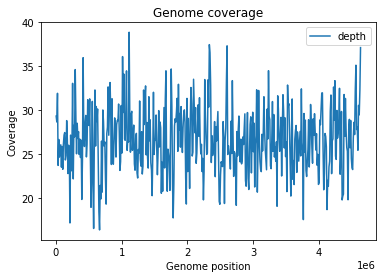

In [5]:
plotGenomeCoverage("data/HW3/nanopore_coverage.txt", 10000)

### Для ридов с PacBio:

Среднее покрытие: 38
Доля покрытой области генома: 100.0%


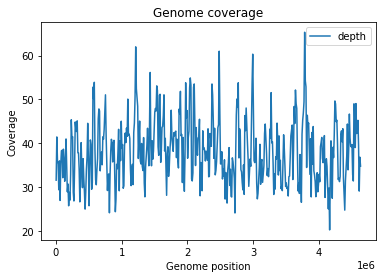

In [6]:
plotGenomeCoverage("data/HW3/pacbio_coverage.txt", 10000)

## Процент ошибок (samtools stats / error rate):  
**NanoPore:** 8.11%  
**PacBio:** 14.21%  

## Распределение типов замен

In [148]:
import pysam
from Bio import SeqIO
from collections import Counter

def getSubsMatrix(referenceFileName, alignmentFileName):

    subsMatrix = np.zeros(shape =(5,5))

    symMap = {"A":0,"C":1,"G":2,"T":3,"a":0,"c":1,"g":2,"t":3,'-':4}

    samfile = pysam.AlignmentFile(alignmentFileName, "rb" )

    seqIo = list(SeqIO.parse(referenceFileName, "fasta"))
    i = 0
    total_count = 0
    bad_count = 0
    for pileupcolumn in samfile.pileup():
        pileup_error_count = 0
        ref_pos = pileupcolumn.reference_pos
        ref_base = seqIo[pileupcolumn.reference_id].seq[ref_pos]
        refBaseSym = symMap[ref_base]
        queries = pileupcolumn.get_query_sequences(add_indels = True)
        for query in queries:
            if('*' in query):
                subsMatrix[4, refBaseSym] += 1
                bad_count+=1
            elif('-' in query):
                continue
            elif('+' in query):
                for sym in query[1:]:
                    if(sym in symMap.keys()):
                        subsMatrix[symMap[sym],4] += 1
                        bad_count+=1
            else:
                subsMatrix[symMap[query], refBaseSym] += 1
                if(query.lower()!=ref_base.lower()):
                    bad_count+=1
            
    matrix = pd.DataFrame(subsMatrix, dtype=int)
    matrix.index = ["A","C","G","T",'-']
    matrix.columns = ["A","C","G","T",'-']

    return matrix, bad_count

In [166]:
def estimateReadsTotalLength(alignmentFileName):
    samfile = pysam.AlignmentFile(alignmentFileName, "rb" )
    total_length = 0
    for read in samfile.fetch():
        total_length+=read.query_alignment_length
    return total_length

### Для NanoPore:

In [150]:
np_matrix, bad_count = getSubsMatrix("/mnt/d/NGS/data/HW3/reference.fasta", "/mnt/d/NGS/data/HW3/nanopore_sorted.bam")

In [164]:
np_matrix

,A,C,G,T,-
A,24961030,18809,49966,16004,193409
C,17662,25574401,13707,71669,180206
G,71509,12653,25740187,17121,190250
T,15743,53596,18338,24858943,179138
-,748805,709977,699991,748596,0


In [167]:
total_length = estimateReadsTotalLength("/mnt/d/NGS/data/HW3/nanopore_sorted.bam")
print "NanoPore error rate: ", round(1.0*bad_count/total_length,3)*100,"%"


NanoPore error rate:  6.3 %


In [152]:
pb_matrix, bad_count = getSubsMatrix("/mnt/d/NGS/data/HW3/reference.fasta", "/mnt/d/NGS/data/HW3/pacbio_sorted.bam")

In [168]:
pb_matrix

,A,C,G,T,-
A,14860015,60676,52398,50584,1307737
C,47895,16178691,56438,43752,1528063
G,43676,55743,15720226,47209,1645838
T,50176,51433,58450,14616101,1261277
-,313440,454538,531606,357279,0


In [170]:
total_length = estimateReadsTotalLength("/mnt/d/NGS/data/HW3/pacbio_sorted.bam")
print "PacBio error rate: ", round(1.0*bad_count/total_length,3)*100,"%"

PacBio error rate:  4.0 %


## Статистика длин инделов

In [16]:
def indelsStat(indelsFileName, skipRow):
    df = pd.read_csv(indelsFileName, sep="\t", usecols=[0,1,2], header=None)
    df = df.rename(columns = {0: "length", 1: "inserts", 2:"deletions"})
    df = df[skipRow:]
    df.plot(x="length", y=["deletions","inserts"])

    plt.ylabel("Количество indels")
    plt.xlabel("Длина indel")
    plt.title("Indels distribution")

### Для NanoPore:

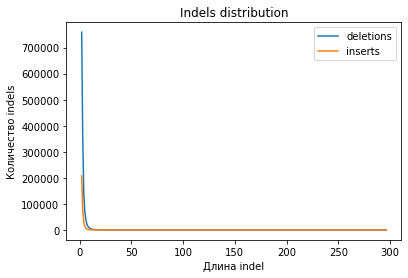

In [32]:
indelsStat("data/HW3/nanopore_indels.txt", 1)

### Для PacBio:

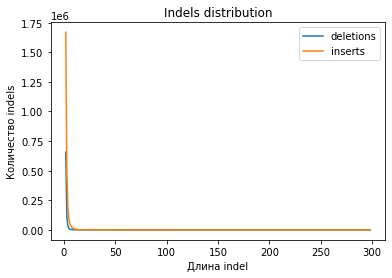

In [31]:
indelsStat("data/HW3/pacbio_indels.txt", 1)

## Сравнение
1.  У PacBio заметно лучше среднее покрытие генома
2.  У PacBio заметно выше процент ошибок
3.  У NanoPore больше делеций и меньше вставок. У PacBio всё наоборот